<a href="https://colab.research.google.com/github/kostique23/Image-Super-Resolution-using-Deep-Convolutional-Autoencoders/blob/main/image-super-resolution-autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ВВОДНАЯ ЧАСТЬ

 * **Тема работы:** Повышение разрешения изображений с помощью автокодировщиков с глубокими сверточными сетями

 * **Автор:** Кулебякин Константин

 * **Аннотация:** В данном проекте реализуются и сравниваются различные архитектуры автокодировщиков для повышения разрешения изображений. Основное внимание уделяется архитектуре U-Net, которая демонстрирует высокую эффективность в задачах восстановления изображения. Для обучения и оценки используется набор данных DIV2K. В качестве метрик качества применяются PSNR (Peak Signal-to-Noise Ratio) и SSIM (Structural Similarity Index).

### УСТАНОВКА И ИМПОРТ БИБЛИОТЕК

In [ ]:
#@title Установка библиотек

!pip install -q tensorflow

In [ ]:
#@title Импорт библиотек

import numpy as np                                                                         # Работа с массивами
import matplotlib.pyplot as plt                                                            # Визуализация
import tensorflow as tf                                                                    # Фреймворк для глубокого обучения
from tensorflow.keras import layers, models                                                # Слои и модели Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator                        # Аугментация данных
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint                      # Callbacks для обучения
from tensorflow.keras.utils import plot_model                                              # Визуализация архитектуры модели
from tqdm import tqdm                                                                      # Progress bar
import os                                                                                  # Работа с файловой системой
import cv2                                                                                 # Библиотека компьютерного зрения OpenCV (для загрузки и изменения размера изображений)
from sklearn.model_selection import train_test_split                                       # Разделение данных на train/test
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr # Метрики качества изображения
import random                                                                              # Для генерации случайных чисел

### ТЕОРЕТИЧЕСКАЯ ЧАСТЬ

* **Краткое описание проблемы:**

 Задача повышения разрешения изображений заключается в увеличении разрешения изображения низкого качества для получения изображения высокого качества с минимальными искажениями.  
 Эта задача актуальна в различных областях, таких как:
  * Медицина: улучшение качества медицинских снимков
  * Спутниковая съемка: детализация изображений земной поверхности
  * Обработка видео: улучшение качества видео
  * Развлечения: улучшение качества фотографий и видеоигр.

* **Основные концепции:**

1. Автоэнкодеры:

 Автоэнкодеры - это нейронные сети, которые обучаются восстанавливать входные данные на выходе. Они состоят из двух основных частей:
 * Кодировщик - сжимает входные данные в компактное представление (латентное пространство)
 * Декодер - восстанавливает исходные данные из латентного представления.

 В контексте повышения разрешения, автоэнкодер обучается на парах изображений низкого и высокого разрешения, стремясь восстановить изображение высокого разрешения из изображения низкого разрешения.  

2. Глубокие сверточные сети (SNN):

 SNN используются в качестве строительных блоков для кодировщика и декодера, благодаря их способности эффективно извлекать пространственные признаки из изображений.

3. Метрики PSNR и SSIM:

 Метрики PSNR и SSIM являются основными инструментами для оценки качества изображений в задачах суперразрешения.

 * PSNR (Пиковое отношение сигнала к шуму):

 PSNR измеряет качество восстановленного изображения на основе разницы между оригиналом и результатом. Оно указывает, насколько сильно восстановленное изображение отклоняется от эталонного.

 Интерпретация:
   1. Чем выше значение PSNR, тем меньше ошибок и лучше качество изображения.
   2. Обычно для хорошего качества изображения PSNR составляет более 30 дБ.

 * SSIM (Индекс структурного сходства):

 SSIM оценивает восприятие изображения, сравнивая структурные элементы, такие как яркость, контрастность и текстура, между оригиналом и восстановленным изображением. Эта метрика более согласуется с человеческим восприятием качества.

 Интерпретация:
   1. Значения SSIM варьируются от 0 до 1, где 1 означает идентичность изображений.
   2. SSIM считается более чувствительным к восприятию человека, чем PSNR.

 Сравнение метрик:
 * PSNR полезен для количественной оценки разницы, но не всегда отражает субъективное качество.
 * SSIM лучше подходит для оценки восприятия качества и структурного сходства.

 В совокупности использование обеих метрик обеспечивает комплексную оценку качества восстановленного изображения.

* **Математическое обоснование:**

 Обучение автоэнкодера для повышения разрешения основано на минимизации функции потерь, которая измеряет разницу между восстановленным изображением высокого разрешения и исходным изображением высокого разрешения. В данной работе используется среднеквадратическая ошибка (MSE) в качестве функции потерь:

  MSE = (1/n) * Σ(yᵢ - ŷᵢ)², где:
    * n - количество пикселей в изображении,
    * yᵢ - значение i-го пикселя в исходном изображении высокого разрешения,
    * ŷᵢ - значение i-го пикселя в восстановленном изображении высокого разрешения.

  В процессе обучения, автоэнкодер настраивает свои веса, чтобы минимизировать MSE, тем самым улучшая качество восстановленных изображений.

* **Используемые архитектуры:**

 В данном проекте мной было выбрано 4 модели автоэнкодера: простой автоэнкодер, усложнённый автоэнкодер, полноценный автоэнкодер и U-Net автоэнкодер.
  
 Эти модели были выбраны, чтобы исследовать различные уровни сложности и эффективности в контексте задачи повышения качества изображений.

  * Простой автоэнкодер был выбран для начала экспериментов, так как представляет собой минималистичную модель с базовой структурой, что позволяет быстрее протестировать основные подходы и методы без сложных вычислительных затрат.

  * Усложнённый автоэнкодер включает дополнительные элементы, такие как нормализация и большее количество фильтров, что делает его более устойчивым и способным к извлечению более сложных признаков. Это важно для изучения влияния этих изменений на качество восстановления изображения.

  * Полноценный автоэнкодер был включён для более глубокого анализа, так как он способен захватывать более детализированные особенности изображения, что критично для задач, связанных с улучшением качества.

  * U-Net автоэнкодер был выбран в качестве самой сложной и продвинутой модели благодаря своей структуре с пропусками, что позволяет эффективно восстанавливать изображения, сохраняя пространственную информацию. Это идеальный выбор для задачи суперразрешения, где важно восстановление мелких деталей.  


1. **Простой автоэнкодер**

 Описание:
 * Архитектура включает только два слоя свёртки.
 * Кодировщик уменьшает изображение до латентного представления, а декодер восстанавливает его обратно.
 * Используется минимальное количество параметров, что делает модель быстрой в обучении, но ограниченной в возможностях.

 Достоинства:
 * Простая и быстрая в обучении.
 * Меньшая вероятность переобучения при использовании небольших данных.

 Недостатки:
 * Недостаточно сложная для захвата глубоких и сложных признаков изображений.
 * Качество восстановления изображения низкое по сравнению с более сложными моделями.

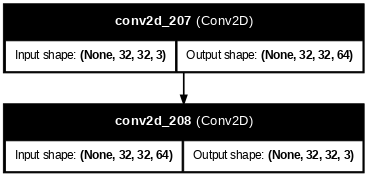

Рис. 1. Схема простого автоэнкодера

2. **Усложнённый автоэнкодер**

 Описание:
 * Добавлен слой нормализации (BatchNormalization), что улучшает обучение и стабилизирует градиенты.
 * Используется большее количество фильтров, что позволяет захватывать более сложные пространственные признаки.

 Достоинства:
 * Устойчивость к изменениям в распределении данных.
 * Лучше справляется с задачами, где требуется большее количество признаков.

 Недостатки:
 * Всё ещё не хватает глубины и сложности для обработки сложных изображений высокого качества.

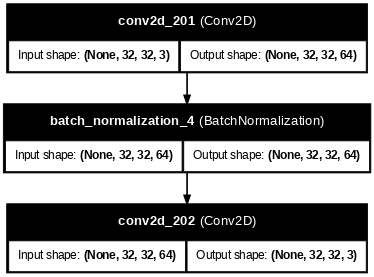

Рис. 2. Схема усложнённого автоэнкодера

3. **Полноценный автоэнкодер**

 Описание:
 * Архитектура включает несколько блоков свёртки и пулинга в кодировщике, а также их зеркальные блоки в декодировщике.
 * Увеличение глубины модели позволяет работать с более сложными структурами изображений.

 Достоинства:
 * Умеет работать с детализированными изображениями.
 * Глубокая архитектура позволяет выделять значимые признаки на различных уровнях.

 Недостатки:
 * Увеличивается вычислительная сложность.
 * Требуется больше данных для предотвращения переобучения.

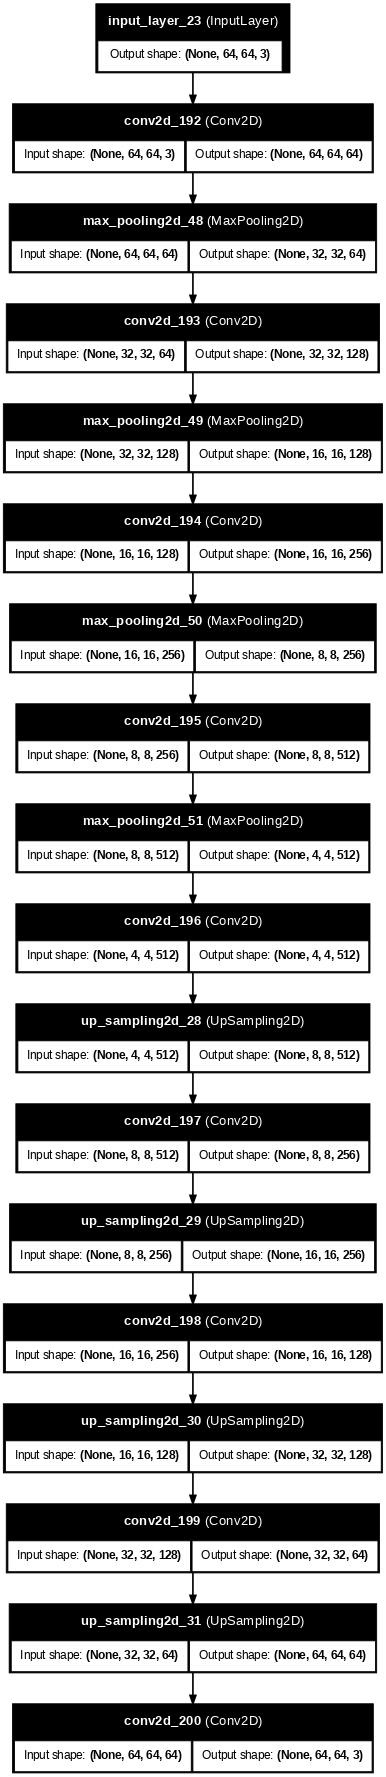

Рис. 3. Схема полноценного автоэнкодера

4. **U-Net автоэнкодер**

 Описание:
 * Основан на архитектуре U-Net, которая включает симметричные кодировочные и декодировочные блоки.
 * Использует механизм пропуска, соединяющий соответствующие уровни кодировщика и декодировщика для сохранения пространственной информации.

 Достоинства:
 * Пропуски позволяют восстанавливать высокочастотные детали изображения.
 * Устойчив к проблеме исчезающих градиентов за счёт прямого соединения между уровнями.
 * Эффективно восстанавливает структуры и текстуры изображения.
 * Наиболее подходящая модель для задачи повышения разрешения изображений.

 Недостатки:
 * Высокая вычислительная сложность.
 * Требует больше времени на обучение.

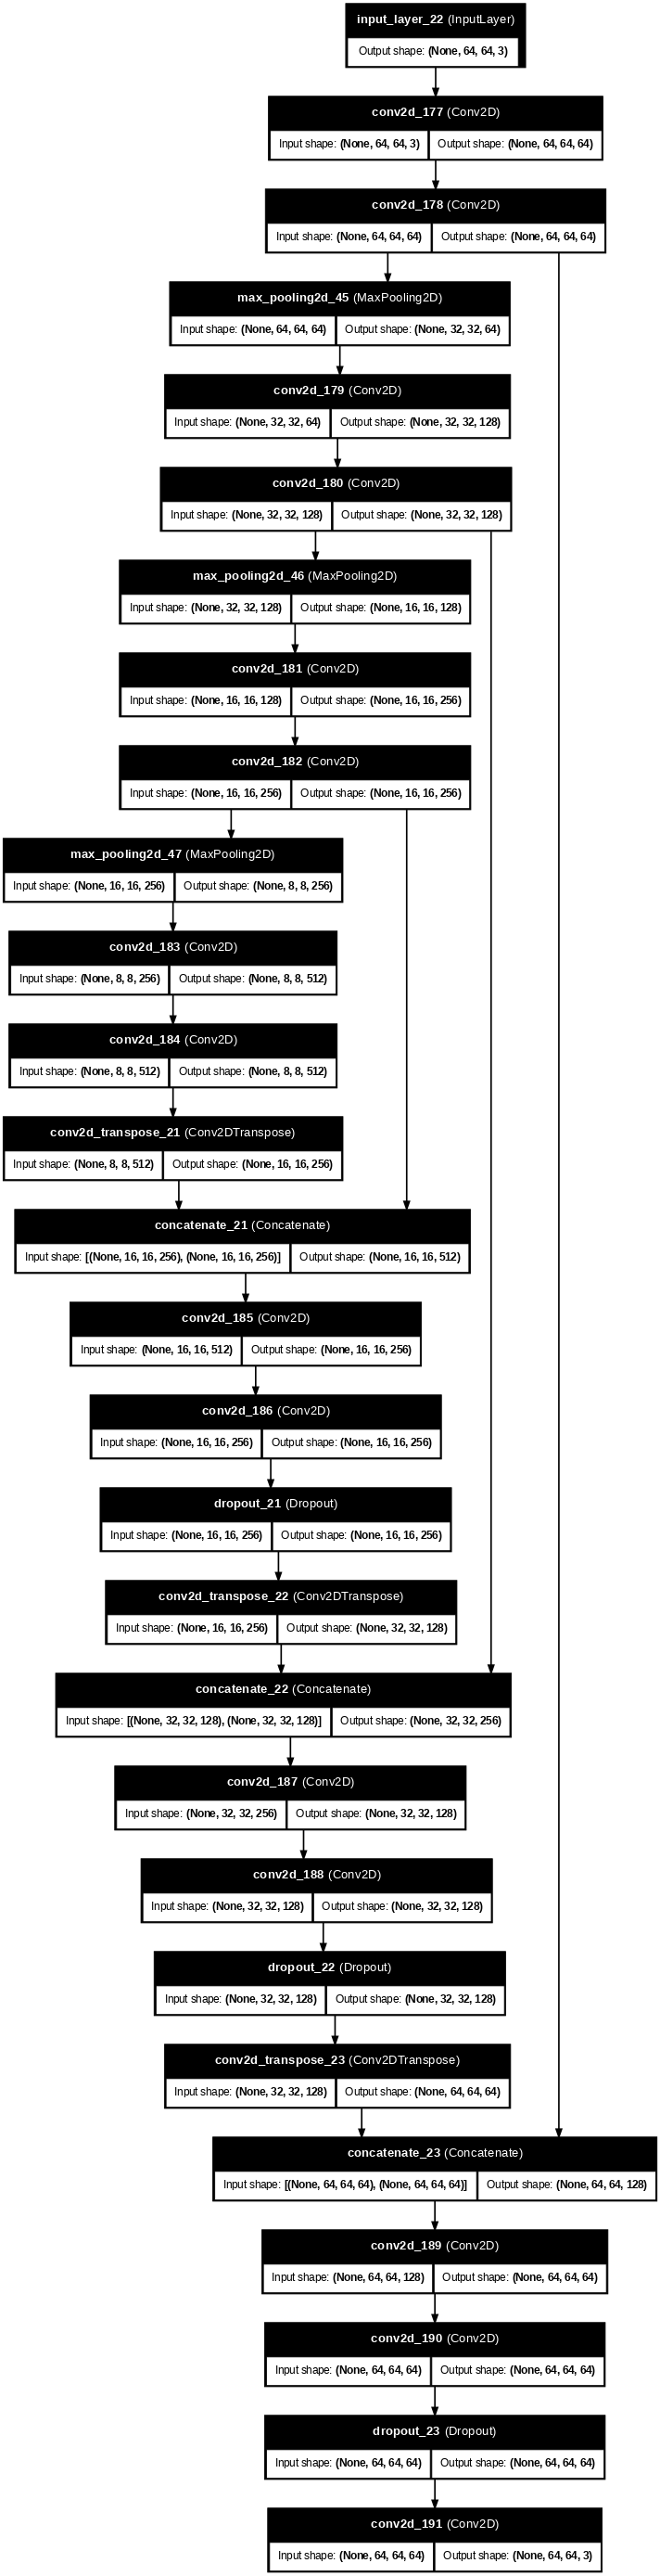

Рис. 4. Схема U-Net автоэнкодера

**Сравнение моделей в контексте задачи:**

| Модель | Простота | Качество восстановления | Подходит для сложных данных | Время обучения |
|-------------------------|--------------|-------------|--------------|----------|
| Простой автоэнкодер     | ✅ ✅ ✅ 🟩 | ✅ 🟩 🟩 🟩 |      ❌      | ✅ ✅ ✅ 🟩 |
| Усложнённый автоэнкодер | ✅ ✅ 🟩 🟩 | ✅ ✅ 🟩 🟩 | ✅ 🟩 🟩 🟩 | ✅ ✅ 🟩 🟩 |
| Полноценный автоэнкодер | ✅ 🟩 🟩 🟩 | ✅ ✅ ✅ 🟩 | ✅ ✅ 🟩 🟩 | ✅ 🟩 🟩 🟩 |
| U-Net автоэнкодер       | ✅ 🟩 🟩 🟩 | ✅ ✅ ✅ ✅ | ✅ ✅ ✅ 🟩 | ✅ 🟩 🟩 🟩 |

Где  ✅ ✅ ✅ ✅ - очень круто👍, а  ✅ 🟩 🟩 🟩 - очень плохо👎

U-Net автоэнкодер является лучшим выбором для задачи повышения качества изображений. Его способность сохранять пространственную информацию и восстанавливать сложные текстуры делает его особенно эффективным. Однако, если ресурсы ограничены, можно рассмотреть использование полноценного автоэнкодера как более лёгкой альтернативы с чуть меньшим качеством.

### ПОДГОТОВКА ДАННЫХ

In [ ]:
#@title Загрузка датасета

!wget https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip

# Распаковка архива
!unzip -qo "DIV2K_train_HR.zip" -d ./DIV2K_train_HR

--2025-01-23 05:16:08--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip’

DIV2K_train_HR.zip  100%[===================>]   3.29G  19.7MB/s    in 3m 10s  

2025-01-23 05:19:19 (17.7 MB/s) - ‘DIV2K_train_HR.zip’ saved [3530603713/3530603713]



In [ ]:
#@title Предобработка данных

# Функция для загрузки изображений
def load_images(path, size=(128, 128, 3)):
    images = []
    for filename in os.listdir(path):
        img_path = os.path.join(path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Преобразование в RGB
                img = cv2.resize(img, (size[0], size[1]))  # Изменение размера
                images.append(img)
    return np.array(images)

# Функция для аугментации изображений
def augment_images(images):

    # Создаем генератор для аугментации (ImageDataGenerator)
    datagen = ImageDataGenerator(
        rotation_range=20,            # Поворот на случайный угол
        width_shift_range=0.2,        # Сдвиг по ширине
        height_shift_range=0.2,       # Сдвиг по высоте
        shear_range=0.2,              # Сдвиг изображения
        zoom_range=0.2,               # Масштабирование
        brightness_range=[0.8, 1.2],  # Изменение яркости
        channel_shift_range=20,       # Случайное смещение цветовых каналов
        horizontal_flip=True,         # Горизонтальное отражение
        vertical_flip = True,         # Вертикальное отражение
        fill_mode='nearest'           # Режим заполнения после преобразования
    )

    augmented_images = []
    for img in images:
        img = img.reshape((1,) + img.shape)  # Добавляем размерность пакета
        # Генерируем 10 аугментированных изображений для каждого исходного
        it = datagen.flow(img, batch_size=1)
        augmented_images.extend([next(it)[0] for _ in range(10)])

    return np.array(augmented_images)

# Загрузка изображений высокого разрешения и аугментация
hr_images = load_images('/content/DIV2K_train_HR/DIV2K_train_HR')
hr_quantity = len(hr_images) # Сохраняем количество изображений до аугментации
hr_images_augmented = augment_images(hr_images)

# Создание изображений низкого разрешения из аугментированных изображений высокого разрешения
lr_images_augmented = [cv2.resize(img, (32, 32)) for img in hr_images_augmented]

# Нормализация изображений
hr_images_processed = np.array(hr_images_augmented) / 255.0
lr_images_processed = np.array(lr_images_augmented) / 255.0

# Проверка данных
print(f"Количество изображений в высоком разрешении (до аугментации): {hr_quantity}")
print(f"Количество изображений в высоком разрешении (после аугментации): {len(hr_images_processed)}")
print(f"Количество изображений в низком разрешении: {len(lr_images_processed)}")

Количество изображений в высоком разрешении (до аугментации): 800
Количество изображений в высоком разрешении (после аугментации): 8000
Количество изображений в низком разрешении: 8000


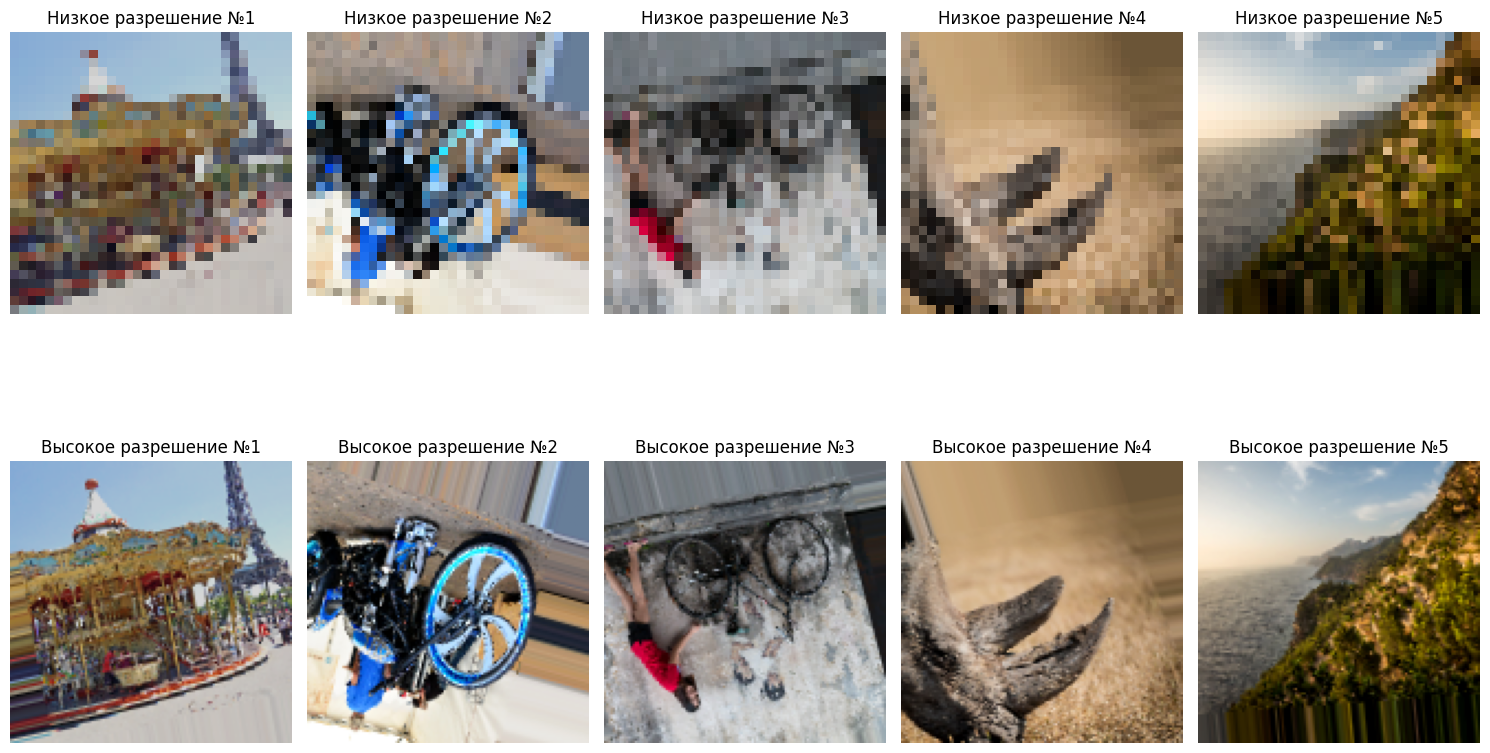

In [ ]:
#@title Визуализация данных

# Генерация случайных индексов для 5 пар изображений
random_indices = random.sample(range(len(lr_images_processed)), 5)

plt.figure(figsize=(15, 10))

# В верхнем ряду отображаем изображения с низким разрешением
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.title(f'Низкое разрешение №{i + 1}')
    plt.imshow(lr_images_processed[idx])
    plt.axis('off')

# В нижнем ряду отображаем соответствующие изображения с высоким разрешением
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 6)
    plt.title(f'Высокое разрешение №{i + 1}')
    plt.imshow(hr_images_processed[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#@title Разделение на train/val/test

train_hr, test_hr, train_lr, test_lr = train_test_split(hr_images_processed, lr_images_processed, test_size=0.2, random_state=42)
val_hr, test_hr, val_lr, test_lr = train_test_split(test_hr, test_lr, test_size=0.5, random_state=42)

# Приводим все выборки к одному размеру
train_hr = tf.image.resize(train_hr, (64, 64))
train_lr = tf.image.resize(train_lr, (64, 64))
val_hr = tf.image.resize(val_hr, (64, 64))
val_lr = tf.image.resize(val_lr, (64, 64))
test_hr = tf.image.resize(test_hr, (64, 64))
test_lr = tf.image.resize(test_lr, (64, 64))

# Проверка размеров данных
print(f"Размер входных данных на обучающей выборке: {train_hr.shape}")
print(f"Размер выходных данных на обучающей выборке: {train_lr.shape}")
print(f"Размер входных данных на валидационной выборке: {val_hr.shape}")
print(f"Размер выходных данных на валидационной выборке: {val_lr.shape}")
print(f"Размер входных данных на тестовой выборке: {test_hr.shape}")
print(f"Размер выходных данных на тестовой выборке: {test_lr.shape}")

Размер входных данных на обучающей выборке: (6400, 64, 64, 3)
Размер выходных данных на обучающей выборке: (6400, 64, 64, 3)
Размер входных данных на валидационной выборке: (800, 64, 64, 3)
Размер выходных данных на валидационной выборке: (800, 64, 64, 3)
Размер входных данных на тестовой выборке: (800, 64, 64, 3)
Размер выходных данных на тестовой выборке: (800, 64, 64, 3)


### РЕАЛИЗАЦИЯ МОДЕЛЕЙ

In [ ]:
#@title Архитектура 1: Простой автоэнкодер

def create_simple_autoencoder(input_shape=(32, 32, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

In [ ]:
#@title Архитектура 2: Усложнёный автоэнкодер

def create_advanced_autoencoder(input_shape=(32, 32, 3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
    ])
    return model

In [ ]:
#@title Архитектура 3: Полноценный автоэнкодер

def create_autoencoder(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    # Кодировщик
    # Первый блок
    conv1 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(inputs)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Второй блок
    conv2 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(pool1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Третий блок
    conv3 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(pool2)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Четвертый блок
    conv4 = layers.Conv2D(512, (3, 3), activation='leaky_relu', padding='same')(pool3)
    encoded = layers.MaxPooling2D((2, 2),)(conv4)


    # Декодировщик
    # Первый блок
    conv5 = layers.Conv2D(512, (3, 3), activation='leaky_relu', padding='same')(encoded)
    up1 = layers.UpSampling2D((2, 2))(conv5)

    # Второй блок
    conv6 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(up1)
    up2 = layers.UpSampling2D((2, 2))(conv6)

    # Третий блок
    conv7 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(up2)
    up3 = layers.UpSampling2D((2, 2))(conv7)

    # Четвертый блок
    conv8 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(up3)
    up4 = layers.UpSampling2D((2, 2))(conv8)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up4)

    model = models.Model(inputs=inputs, outputs=decoded)
    return model

In [ ]:
#@title Архитектура 4: U-NET автоэнкодер

def create_unet(input_shape=(64, 64, 3)):
    inputs = layers.Input(shape=input_shape)

    # Кодировщик
    # Первый блок
    conv1 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Второй блок
    conv2 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Третий блок
    conv3 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Четвертый блок
    conv4 = layers.Conv2D(512, (3, 3), activation='leaky_relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='leaky_relu', padding='same')(conv4)

    # Декодировщик
    # Первый блок
    up1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), activation='leaky_relu')(conv4)
    trans1 = layers.Concatenate()([up1, conv3])
    conv5 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(trans1)
    conv5 = layers.Conv2D(256, (3, 3), activation='leaky_relu', padding='same')(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Второй блок
    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), activation='leaky_relu')(conv5)
    trans2 = layers.Concatenate()([up2, conv2])
    conv6 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(trans2)
    conv6 = layers.Conv2D(128, (3, 3), activation='leaky_relu', padding='same')(conv6)
    conv6 = layers.Dropout(0.5)(conv6)

    # Третий блок
    up3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), activation='relu')(conv6)
    trans3 = layers.Concatenate()([up3, conv1])
    conv7 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(trans3)
    conv7 = layers.Conv2D(64, (3, 3), activation='leaky_relu', padding='same')(conv7)
    conv7 = layers.Dropout(0.5)(conv7)

    # Четвертый блок
    decoded = layers.Conv2D(3, (3, 3), activation='tanh', padding='same')(conv7)

    model = models.Model(inputs=inputs, outputs=decoded)
    return model

### ОБУЧЕНИЕ

In [ ]:
#@title Обучение моделей

# Словарь с моделями для тестирования
models_to_test = {
"Простой автоэнкодер": create_simple_autoencoder(),
"Усложнёный автоэнкодер": create_advanced_autoencoder(),
"Полноценный автоэнкодер": create_autoencoder(),
"U-Net автоэнкодер": create_unet()
}

# Параметры обучения
results = {}
epochs = 100
batch_size = 256

for name, model in models_to_test.items():
    print("")
    print(f"Обучение модели {name}:")

    # Создаем директорию для чекпоинтов модели
    checkpoint_dir = os.path.join("checkpoints", name)
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Создаем callback для сохранения чекпоинтов
    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, "model_{epoch:02d}.keras"),
        monitor='val_loss',
        mode='min',
        save_best_only=True,     # Сохраняем только лучшую модель (с минимальным val_loss)
        save_weights_only=False, # Сохраняем всю модель, а не только веса
        verbose=1                # Выводим сообщения о сохранении чекпоинтов
    )

    # Создаем callback EarlyStopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,                 # Количество эпох без улучшения, после которых обучение останавливается
        restore_best_weights=True,  # Восстанавливаем веса лучшей эпохи
    )

    # Компилируем модель
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    history = model.fit(
        train_lr,
        train_hr,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_lr, val_hr),
        callbacks=[checkpoint_callback, early_stopping]
    )
    results[name] = history.history


Обучение модели Простой автоэнкодер:
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0722 - mse: 0.0722
Epoch 1: val_loss improved from inf to 0.05631, saving model to checkpoints/Простой автоэнкодер/model_01.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0563 - val_mse: 0.0563
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0483 - mse: 0.0483
Epoch 2: val_loss improved from 0.05631 to 0.02353, saving model to checkpoints/Простой автоэнкодер/model_02.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0480 - mse: 0.0480 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 3/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0182 - mse: 0.0182
Epoch 3: val_loss improved from 0.02353 to 0.00871, saving model to checkpoints/Простой автоэнкодер/model_03.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss

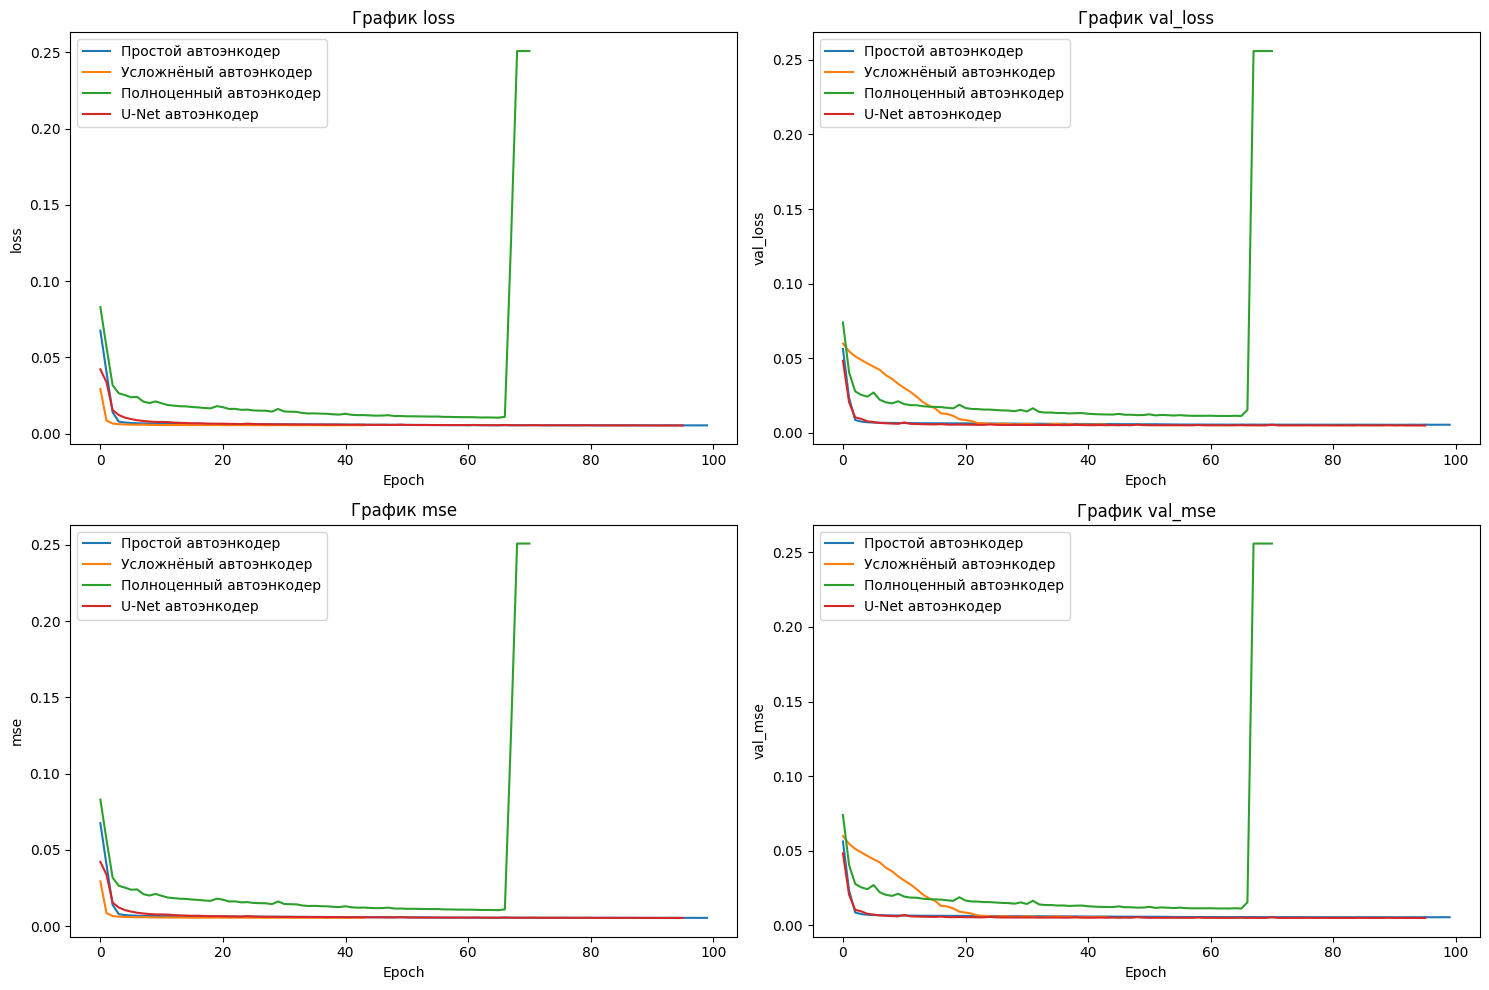

In [ ]:
#@title Графики метрик

 # Список метрик для отображения
metrics = ['loss', 'val_loss', 'mse', 'val_mse']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)  # Используем сетку 2x2 для отображения 4 графиков
    for name, history in results.items():
        plt.plot(history[metric], label=f'{name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.title(f"График {metric}")
    plt.legend()

plt.tight_layout()
plt.show()



### ОЦЕНКА РЕЗУЛЬТАТОВ

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


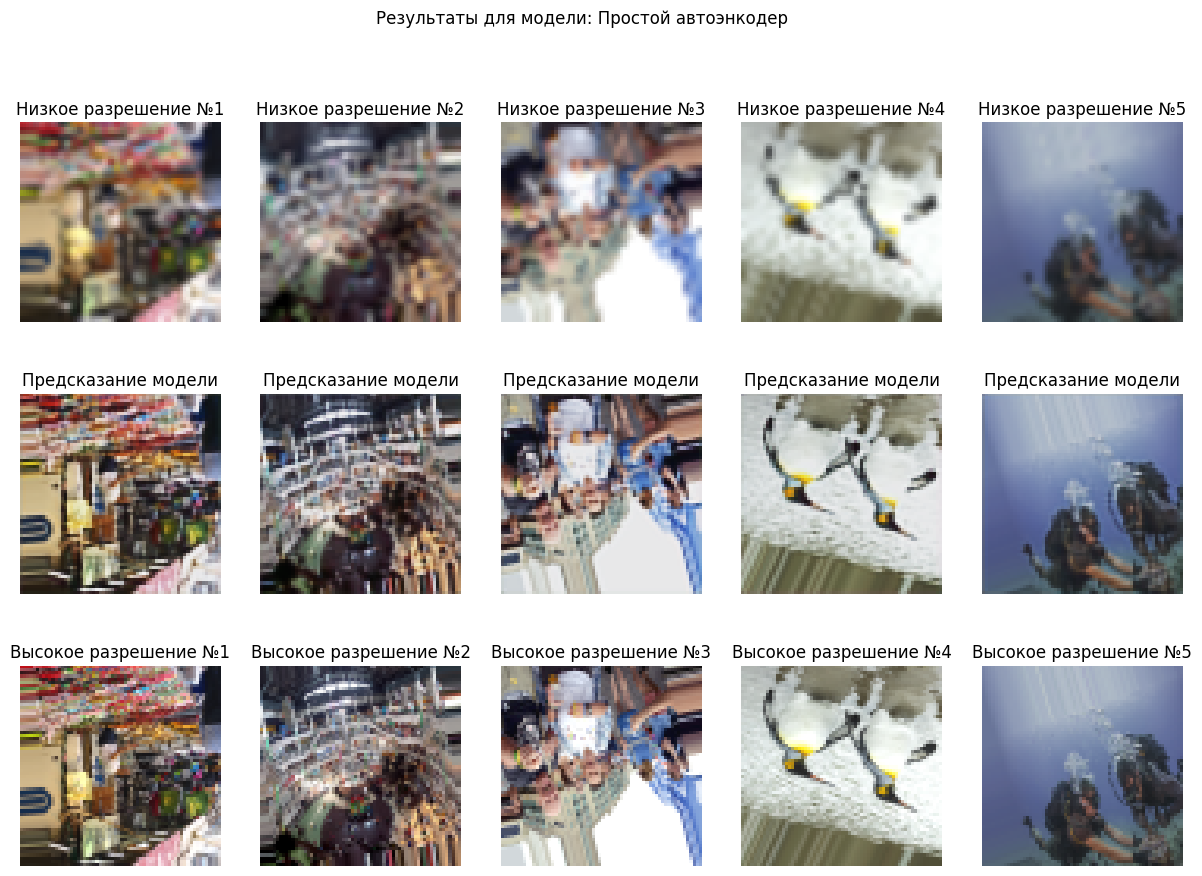

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


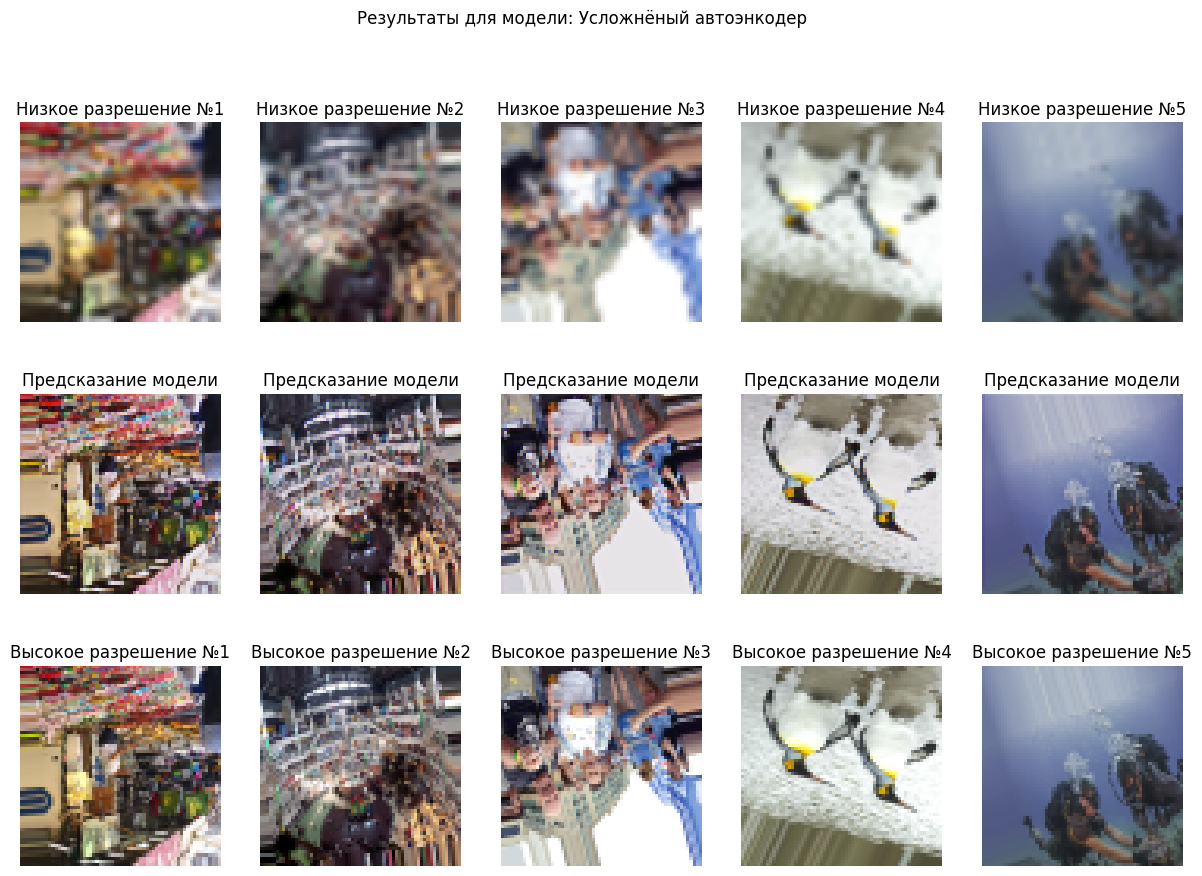

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


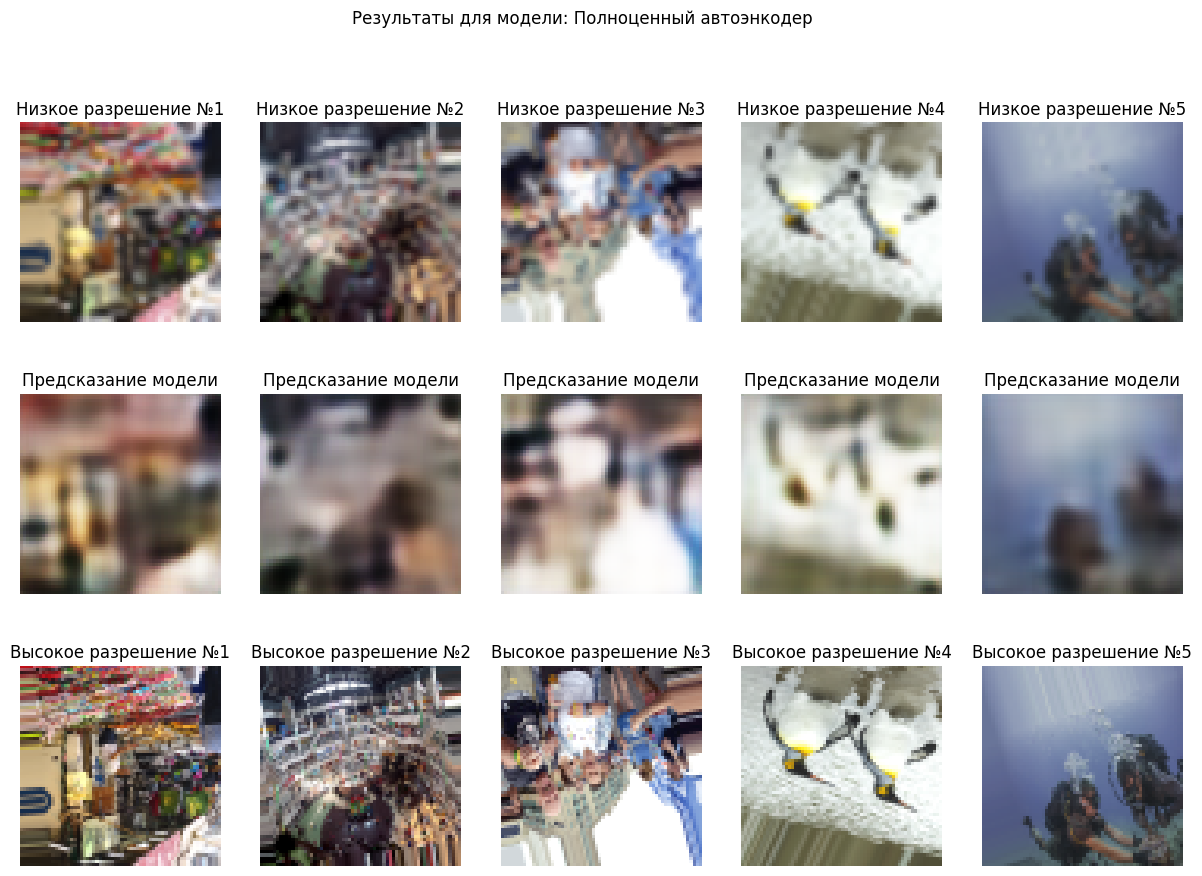

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


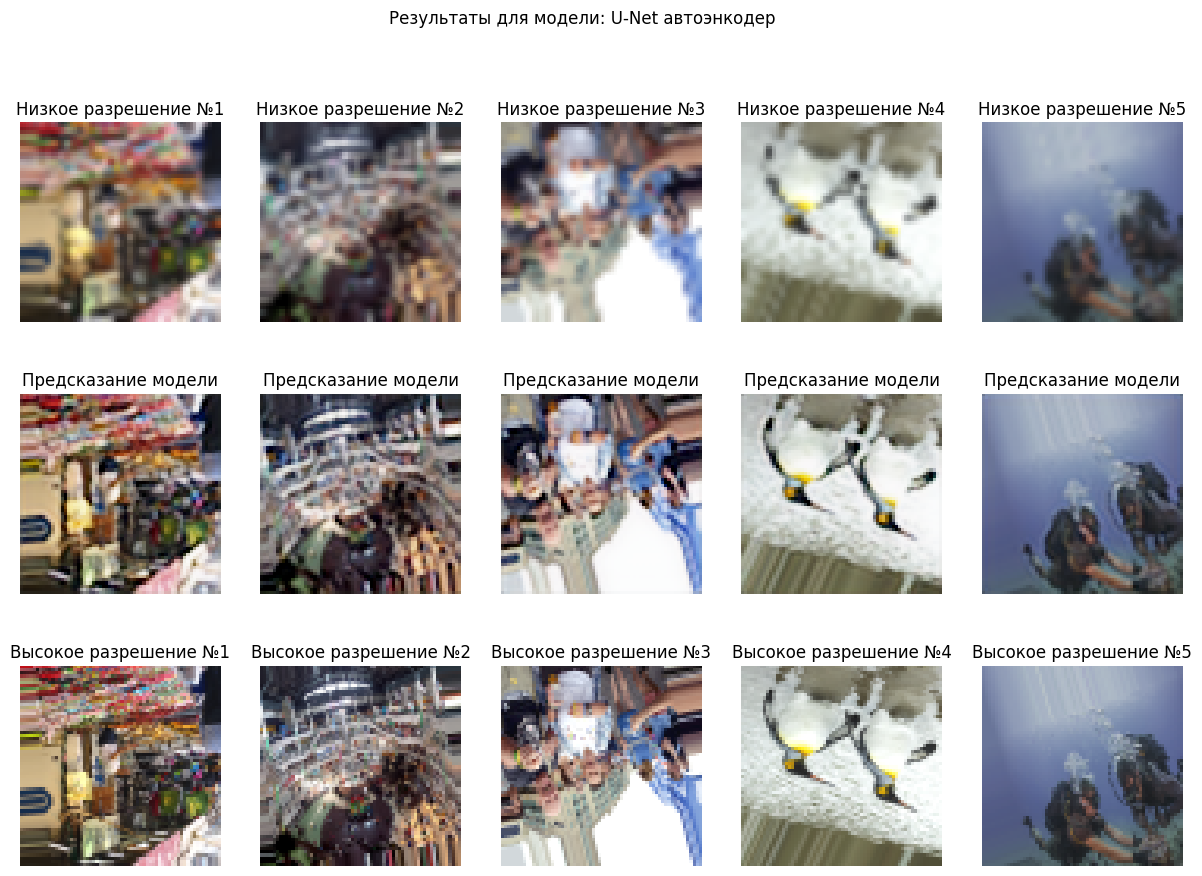

In [ ]:
#@title Визуализация результатов для каждой модели

for name, model in models_to_test.items():

    # Генерация предсказаний
    predictions = model.predict(test_hr)         # Предсказываем изображения высокого разрешения по изображениям test_hr
    predictions = np.clip(predictions, 0.0, 1.0) # Ограничиваем значения пикселей от 0 до 1

    # Ограничиваем количество изображений для визуализации
    n_images = min(5, len(predictions))
    fig, axes = plt.subplots(3, n_images, figsize=(15, 10))

    for i in range(n_images):
        axes[0, i].imshow(test_lr[i])
        axes[0, i].set_title(f'Низкое разрешение №{i + 1}')
        axes[0, i].axis('off')

        axes[1, i].imshow(predictions[i])
        axes[1, i].set_title("Предсказание модели")
        axes[1, i].axis('off')

        axes[2, i].imshow(test_hr[i])
        axes[2, i].set_title(f'Высокое разрешение №{i + 1}')
        axes[2, i].axis('off')

    plt.suptitle(f"Результаты для модели: {name}")  # Заголовок для всей фигуры
    plt.show()

In [ ]:
#@title # Расчет метрик

for name, model in models_to_test.items():
    print("")
    print(f"Оценка модели {name}:")
    predictions = model.predict(test_hr) # Предсказываем изображения высокого разрешения

    # Преобразование предсказаний в формат float64 для skimage.metrics
    predictions = np.array(predictions, dtype=np.float64)

    # Преобразование test_hr в NumPy массив для skimage.metrics
    test_hr_np = np.array(test_hr, dtype=np.float64)

    # Инициализация списков для метрик
    psnr_values = []
    ssim_values = []

    for i in range(len(predictions)):
        # Получаем размеры текущих изображений
        hr_shape = test_hr[i].shape
        pred_shape = predictions[i].shape

        # Проверяем минимальный размер текущих изображений
        min_dim = min(hr_shape[0], hr_shape[1], pred_shape[0], pred_shape[1])

        # Устанавливаем win_size безопасно, чтобы избежать ошибок
        win_size = min(min_dim, 7)  # Ограничиваем значение win_size
        if win_size % 2 == 0:
            win_size -= 1  # Делаем win_size нечётным

        # Рассчитываем PSNR и SSIM для текущего изображения
        try:
            psnr_values.append(psnr(test_hr_np[i], predictions[i], data_range=1.0)) # Используем test_hr_np
            ssim_values.append(
                ssim(
                    test_hr_np[i], predictions[i], # Используем test_hr_np
                    channel_axis=-1,               # Указываем ось каналов
                    data_range=1.0,                # Динамический диапазон пикселей
                    win_size=win_size              # Размер скользящего окна
                )
            )
        # Обработка потенциальных ошибок
        except ValueError as e:
            print(f"  Ошибка при расчете метрик: {e}")
            continue

    # Вывод средних метрик
    if psnr_values and ssim_values:  # Убедимся, что списки не пустые
        print(f"Средний PSNR: {np.mean(psnr_values):.4f}")
        print(f"Средний SSIM: {np.mean(ssim_values):.4f}")
    else:
        print("Недостаточно данных для расчета метрик.")


Оценка модели Простой автоэнкодер:
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Средний PSNR: 30.0854
Средний SSIM: 0.9556

Оценка модели Усложнёный автоэнкодер:
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Средний PSNR: 29.2855
Средний SSIM: 0.9531

Оценка модели Полноценный автоэнкодер:
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Средний PSNR: 20.0900
Средний SSIM: 0.5151

Оценка модели U-Net автоэнкодер:
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Средний PSNR: 28.1222
Средний SSIM: 0.9358


### ВЫВОДЫ

* **Основные результаты:**

 * В данном проекте были исследованы четыре различные архитектуры автоэнкодеров для задачи повышения разрешения изображений. Обучение проводилось на датасете DIV2K с использованием метрик PSNR и SSIM для оценки качества.

 * Простой и Усложненный автоэнкодеры показали хорошие результаты по метрикам PSNR (30.09 и 29.29 соответственно) и SSIM (0.96 и 0.95 соответственно).
 Эти модели быстро обучаются и имеют небольшое количество параметров, что делает их подходящими для применений с ограниченными ресурсами. Усложненный автоэнкодер, благодаря слою пакетной нормализации, продемонстрировал более стабильное обучение.

 * Полноценный автоэнкодер показал худшие результаты по сравнению с простыми моделями (PSNR 20.09, SSIM 0.52). Более глубокая архитектура в этом случае не привела к повышению качества реконструкции, возможно, из-за переобучения на небольшом объеме данных. Также стоит отметить, что эта модель обучается дольше, чем простые автоэнкодеры.

 * U-Net автоэнкодер продемонстрировал сравнимые с простыми автоэнкодерами результаты по PSNR (28.12) и SSIM (0.94). U-Net обладает большим количеством параметров и обучается значительно дольше. Skip-connections в U-Net, теоретически, должны помогать сохранять детали при повышении разрешения, но в данном случае это преимущество не проявилось в полной мере, вероятно из-за малого количества эпох обучения.

* **Проблемы и ограничения:**

 * Полноценный автоэнкодер:

  Обучение стало неустойчивым после 60-й эпохи, что могло быть вызвано слишком сложной архитектурой или высокой скоростью обучения.

 * Ограниченный объем данных:

  Использование датасета DIV2K может ограничивать производительность моделей и приводить к переобучению из-за нехватки данных для обучения.

 * Вычислительные ресурсы:

  Обучение U-Net занимает значительное время на CPU. Поэтому требуется использование GPU, что ставит в определенные ресурсные рамки.

 * Выбор гиперпараметров: Результаты могут быть улучшены путем более тщательного подбора гиперпараметров моделей, таких как количество фильтров, размер ядра, функции активации и оптимизатора.

 * Метрики PSNR и SSIM: Эти метрики не всегда точно отражают субъективное восприятие качества изображения человеком.

* **Возможные улучшения:**

 * Использовать другой более обширный датасет. Это позволит моделям обучиться более общим признакам и улучшить качество повышения разрешения.

 * Оптимизировать архитектуры моделей: Исследовать разные варианты архитектур, количества слоев, фильтров и т.д.

 * Подобрать оптимальные гиперпараметры. Это может значительно улучшить производительность моделей.

 * Использовать более продвинутые методы аугментации данных. Это может помочь уменьшить переобучение и улучшить обобщающую способность моделей.

 * Исследовать другие метрики качества изображений, например LPIPS или FID.

 * Исследовать модели на других архитектурах или модификациях автоэнкодеров, таких как вариационные автоэнкодеры или GAN-основанные подходы.

В целом, проект показал, что архитектуры автоэнкодеров могут эффективно решать задачи улучшения разрешения изображений, однако требуется дальнейшая работа над оптимизацией моделей и их обучением.